# Report
---

This report contains description of basic experimental setup with conclusions and proposals for next steps. All experiments included into the repo passed success criteria. 
Main sections: 
   
 **1) Experiment overiew** - Description of method used to train agent.  
 **2) Experiment metadata** - Introduction to experiments metadata and its basic usage.    
 **3) Evaluation of model** - Showcase of model usage   
 **4) Evaluation of results** - Some detailed plots and measurements.   
 **5) Next steps**  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import logging
import numpy as np
import pickle
import time
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
import torch
from ac_continuous_control.environment import UnityEnvironmentWrapper
from ac_continuous_control.replay_buffer import ReplayBuffer
from ac_continuous_control.agent import Agent
from ac_continuous_control.training import ac_training

In [4]:
def get_avg_scores(scores, n_samples):
    cs = np.cumsum(scores)
    diff = cs[n_samples:] - cs[:-n_samples]
    avg = diff / n_samples
    return avg
    
def get_best_avg_score(scores, n_samples):
    avg = get_avg_scores(scores, n_samples)
    idxs = np.argsort(avg)[::-1][:3]
    avg_subset = avg[idxs]
    
    return idxs + n_samples, avg_subset

def get_occurance(scores, n_samples, value):
    avg = get_avg_scores(scores, n_samples)
    return np.where(avg >= value)[0][0] + n_samples


## Experiment overview

**Intro**   
To solve Reacher environment, we have applied **ddpg algorithm** [[1]](https://arxiv.org/pdf/1509.02971.pdf). This algorithm use actor critic architecture, where actor predicts best possible action for current state and critict evaluate this decision. Because of stability, we used regular and target version of both actor and critic model with soft updates.

To address exploration-exploitation problem, we generate random noise with Ornstein-Uhlenbeck process which we mix together with actions from actor (original idea was used in Udacity [ddpg bidepadl environmnet task](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal))

**Agent**   
Both actor and critic are feed forward neural networks. Actor has 3 layers with relu activations, output has action space size. Critic has also 3 layers of feedforward network, input to 1st layer is state vector, action vector is concatenated to 2nd layer result.
  
  Params
    * state_size (33): dimension of each state
    * action_size (4): dimension of each action
    * buffer_size (1e5): Replay buffer size
    * batch_size (128): Size of sampled batches from replay buffer
    * lr_actor (1e-4): Learning rate
    * lr_critic (1e-4): Learning rate
    * gamma (0.99): Reward discount
    * tau (1e-3): Soft update of target network parameters

**Training**  
For training purposes we have used multi-agent environment with shared weights across agents. These were periodically updated. Trained result can be applied to varinous number of robotic arms..

## Experiment metadata

Experiment in repo has it's own metadata file with details of experiemnt and of course separate pytorch weights of trained agent (separatelly for actor and critic). Lets have a look at ```../experiments/basic``` which contains results for basic ddpg setup

In [5]:
meta = pickle.load(open('../experiments/basic/meta.pickle', 'rb'))

In [6]:
# repr string for agent initialization
meta['agent']

'Agent(state_size=33, action_size=4, num_agents=20, device="cuda")'

In [7]:
# result scores during training
meta['scores'][100:110]

[34.947999218851329,
 36.904499175120144,
 35.337499210145324,
 35.199999213218689,
 36.542999183200301,
 37.283499166648838,
 38.387999141961338,
 38.475999139994386,
 37.802999155037107,
 38.092999148555101]

## Evaluation of model

In [8]:
#env = UnityEnvironmentWrapper(env_binary='../bin/reacher_single/Reacher.x86_64', train_mode=False)
env = UnityEnvironmentWrapper(env_binary='../bin/reacher_multi/Reacher.x86_64', train_mode=False)

DEBUG:unityagents:The true file name is Reacher
DEBUG:unityagents:This is the launch string /home/adam/code/ac_continuous_control/notebooks/../bin/reacher_multi/Reacher.x86_64
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [9]:
agent = Agent(state_size=env.state_size, action_size=env.action_size, num_agents=env.num_agents, device='cuda')

In [10]:
agent.load('../experiments/basic/model')

In [12]:
# Evauation of chosen model with reward evolution
states = env.reset()
agent.reset()
score = np.zeros([env.num_agents])
old_mean_score = 0
current_mean_score = 0
for step in range(1000):
    actions = agent.act(states)
    next_states, rewards, dones = env.step(actions)
    agent.step(states, actions, rewards, next_states, dones)
    states = next_states
    score += rewards
    if np.any(np.array(rewards)>0):
        current_mean_score = np.mean(score, axis=0)
        if current_mean_score > old_mean_score + 1:
            old_mean_score = current_mean_score
            print(f'Score update: {current_mean_score}')
    time.sleep(0.05)
    if np.any(dones):
        break

Score update: 1.0219999771565198
Score update: 2.0224999547936022
Score update: 3.0339999321848152
Score update: 4.056499909330159
Score update: 5.096499886084348
Score update: 6.105999863520265
Score update: 7.137999840453267
Score update: 8.148499817866831
Score update: 9.166999795101583
Score update: 10.193999772146345
Score update: 11.216999749280513
Score update: 12.256999726034701
Score update: 13.29699970278889
Score update: 14.311999680101872
Score update: 15.338999657146633
Score update: 16.342999634705485
Score update: 17.35599961206317
Score update: 18.389499588962643
Score update: 19.393499566521495
Score update: 20.411499543767423
Score update: 21.45149952052161
Score update: 22.4914994972758
Score update: 23.53049947405234
Score update: 24.57049945080653
Score update: 25.61049942756072
Score update: 26.650499404314907
Score update: 27.65849938178435
Score update: 28.691999358683823
Score update: 29.73149933544919
Score update: 30.771499312203378
Score update: 31.811499288

In [9]:
env.close()

## Evaluation of results
We have run basic mutiagent ddpg setup. Plots you will see represetns progress over binned scores during training. Each line represetns gourp of scores in given bin with its variance.

In [13]:
meta_basic = pickle.load(open('../experiments/basic/meta.pickle', 'rb'))
data_basic = pd.DataFrame({'scores': meta_basic['scores'], 'iterations': range(len(meta_basic['scores']))})

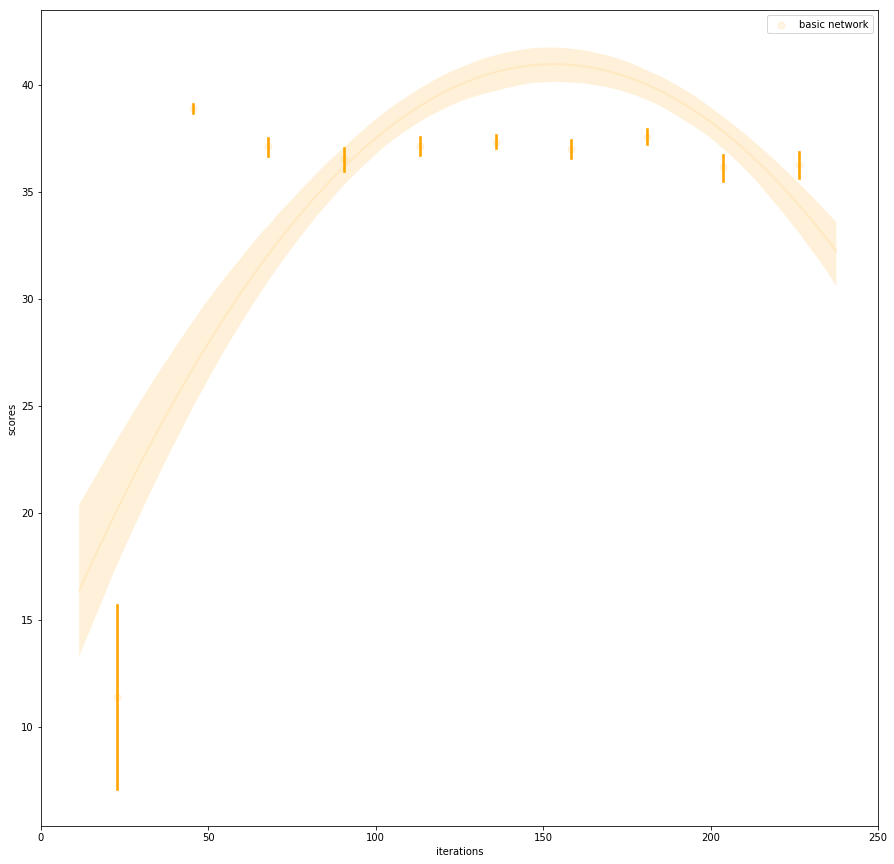

In [16]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
plt.xlim(0, 250)
plt.legend()

In [17]:
print(f'Percentile scores')
print(np.percentile(meta_basic['scores'], [5, 25, 50, 75, 95]))


Percentile scores
[  2.13424995  35.5991242   36.98624917  38.04137415  38.97947413]


In [18]:
print(f'Mean score after 250 runs: {np.mean((meta_basic["scores"]))}')

Mean score after 250 runs: 33.56804324969575


In [19]:
# gives iteration with top scores for given experiment and avg scores (here counted for 30 consecutive samples)
get_best_avg_score(meta_basic['scores'], 30)

(array([61, 62, 60]), array([ 38.80599913,  38.76539913,  38.75269913]))

In [20]:
# iteration when we for the first time reached avg score for 100 consecutive scores >=30
get_occurance(meta_basic['scores'], n_samples=100, value=30)

103

Text(0.5,0.98,'Plot of raw scores got from each single iteration')

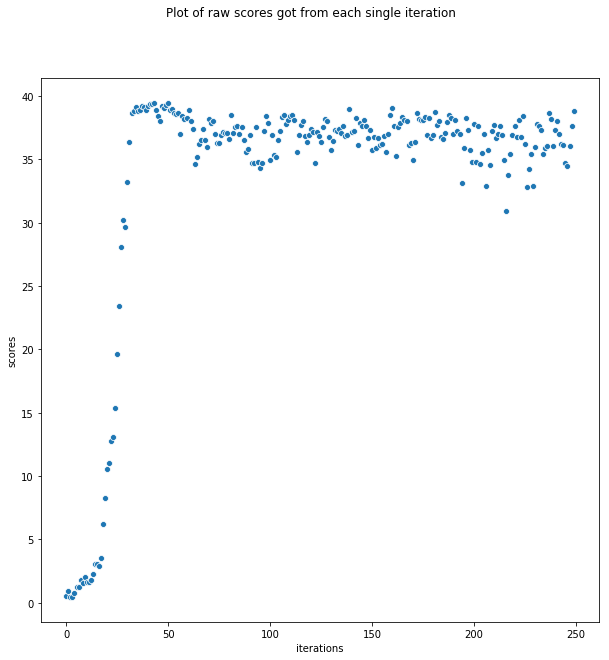

In [21]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(x='iterations', y='scores', data=data_basic, ax=ax)
plt.suptitle('Plot of raw scores got from each single iteration')

We can see that we reached avg score 30 over 100 consecutive measurements on 103. iteration In scatterplot, there is massive boost in scores after ~25 itereations, then it stays pretty stable.

## Next steps

 - experiment with architectures of actor and critic
 - tune up all hyperparameters
 - save models with final result of Ornstein-Uhlenbeck process